-------------- LLama Qlora

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, CLIPProcessor, CLIPModel
from peft import get_peft_model, LoraConfig, prepare_model_for_kbit_training
from datasets import load_dataset
from sklearn.metrics import accuracy_score
import numpy as np
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt

dataset = load_dataset("derek-thomas/ScienceQA")

dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)  # 80% train, 20% validation

dataset["train"] = dataset["train"].shuffle(seed=42).select(range(10000))

# Inspect the resulting dataset
print("Dataset splits:", dataset.keys())
print(dataset)

Dataset splits: dict_keys(['train', 'test'])
DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 2546
    })
})


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x202>,
 'question': 'Is cheese a mineral?',
 'choices': ['no', 'yes'],
 'answer': 0,
 'hint': 'Cheese has the following properties:\nmade in a cheese factory\nnot a pure substance\nsolid\nno fixed crystal structure',
 'task': 'yes or no',
 'grade': 'grade5',
 'subject': 'natural science',
 'topic': 'earth-science',
 'category': 'Rocks and minerals',
 'skill': 'Identify rocks and minerals',
 'lecture': 'Properties are used to identify different substances. Minerals have the following properties:\nIt is a solid.\nIt is formed in nature.\nIt is not made by organisms.\nIt is a pure substance.\nIt has a fixed crystal structure.\nIf a substance has all five of these properties, then it is a mineral.\nLook closely at the last three properties:\nA mineral is not made by organisms.\nOrganisms make their own body parts. For example, snails and clams make their shells. Because they are made by organisms, body parts cannot be minera

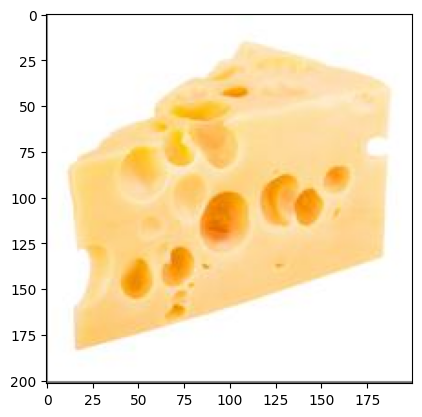

In [4]:
ie = dataset['test'][1]
plt.imshow(ie['image'])
ie

# Importing Libraries

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, CLIPProcessor, CLIPModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score
import numpy as np
from transformers import TrainingArguments, Trainer
from typing import Dict, List
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from transformers import BitsAndBytesConfig

# Defining the Multimodal Preprocessor

In [3]:
class MultimodalPreprocessor:
    def __init__(self, tokenizer, clip_processor, max_length: int = 512):
        self.tokenizer = tokenizer
        self.clip_processor = clip_processor
        self.max_length = max_length

    def format_prompt(self, example: Dict) -> str:
        return (
            f"[INST] Question: {example['question']}\n"
            f"Options: {' | '.join(example['choices'])}\n"
            f"Hint: {example.get('hint', '')}\n"
            f"Based on the image and information provided, select the correct answer. [/INST]"
        )

    def format_response(self, example: Dict) -> str:
        return f"The correct answer is: {example['choices'][example['answer']]}"

    def process_text(self, example: Dict) -> Dict:
        prompt = self.format_prompt(example)
        response = self.format_response(example)
        
        model_inputs = self.tokenizer(
            prompt,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        labels = self.tokenizer(
            response,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        labels = labels["input_ids"].masked_fill(
            labels["input_ids"] == self.tokenizer.pad_token_id, -100
        )
        return {
            "input_ids": model_inputs["input_ids"].squeeze(),
            "attention_mask": model_inputs["attention_mask"].squeeze(),
            "labels": labels.squeeze()
        }

    def process_image(self, image) -> Dict:
        """Process image inputs using CLIP."""
        import torch  

        if image is None:
            return {"pixel_values": torch.zeros((3, 224, 224))}
        
        processed = self.clip_processor(
            images=image,
            return_tensors="pt",
            padding=True
        )
        return {"pixel_values": processed["pixel_values"].squeeze()}


    def __call__(self, example: Dict) -> Dict:
        text_features = self.process_text(example)
        image_features = self.process_image(example.get("image"))
        return {**text_features, **image_features}

# Setting up the Model

In [4]:
def setup_model(model_name: str, device_map: str = "auto"):
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map=device_map,
        trust_remote_code=True,
        torch_dtype=torch.bfloat16,
    )
    model.gradient_checkpointing_enable()
    model = prepare_model_for_kbit_training(model)
    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )
    model = get_peft_model(model, lora_config)
    return model


# Load dataset and preprocess

In [19]:

dataset = load_dataset("derek-thomas/ScienceQA", cache_dir="./my_unique_cache")
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
dataset["train"] = dataset["train"].shuffle(seed=42).select(range(10000))

# Initialize tokenizer and processor
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Ensure tokenizer has a padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Definning the preprocessor
preprocessor = MultimodalPreprocessor(tokenizer, clip_processor)

def is_valid(example):
    return (
        isinstance(example.get("question"), str)
        and isinstance(example.get("choices"), list)
        and isinstance(example.get("answer"), int)
        and 0 <= example["answer"] < len(example["choices"])
    )

filtered_dataset = dataset.filter(is_valid)
tokenized_dataset = filtered_dataset.map(
    preprocessor,
    remove_columns=dataset["train"].column_names,  
    load_from_cache_file=False,
    num_proc=1  
)


Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

# Trainable Parameters

In [20]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params:,d} || "
        f"all params: {all_param:,d} || "
        f"trainable%: {100 * trainable_params / all_param:.4f}"
    )

# Initializing the Model and Printing the Parameters

In [21]:
model_name = "meta-llama/Llama-2-7b-chat-hf"
model = setup_model(model_name)
print_trainable_parameters(model)

c:\Users\Nitro\AppData\Local\Programs\Python\Python310\new_env_3.10\lib\site-packages\huggingface_hub\file_download.py:651: UserWarning: Not enough free disk space to download the file. The expected file size is: 9976.58 MB. The target location C:\Users\Nitro\.cache\huggingface\hub\models--meta-llama--Llama-2-7b-chat-hf\blobs only has 9178.02 MB free disk space.
  warnings.warn(


model-00001-of-00002.safetensors:   9%|8         | 849M/9.98G [00:00<?, ?B/s]

c:\Users\Nitro\AppData\Local\Programs\Python\Python310\new_env_3.10\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nitro\.cache\huggingface\hub\models--meta-llama--Llama-2-7b-chat-hf. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

trainable params: 16,777,216 || all params: 3,517,190,144 || trainable%: 0.4770


# Definning TrainingArguments and Trainer


In [22]:
training_args = TrainingArguments(
    output_dir="./fine_tuned_llama_scienceqa",
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_dir="./logs",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    learning_rate=1e-4,
    weight_decay=0.01,
    warmup_steps=50,
    save_total_limit=3,
    fp16=False,
    gradient_checkpointing=True,
    logging_steps=10,
    report_to="tensorboard",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\Nitro\AppData\Local\Temp\ipykernel_9940\4229381558.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Training

In [ ]:
import time
start_time = time.time()
trainer.train()
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")


  0%|          | 0/1250 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


{'loss': 11.6609, 'grad_norm': 4.051347255706787, 'learning_rate': 2e-05, 'epoch': 0.01}
{'loss': 10.202, 'grad_norm': 5.461788177490234, 'learning_rate': 4e-05, 'epoch': 0.02}
{'loss': 8.3962, 'grad_norm': 4.04346227645874, 'learning_rate': 6e-05, 'epoch': 0.02}
{'loss': 6.0047, 'grad_norm': 4.379866600036621, 'learning_rate': 8e-05, 'epoch': 0.03}
{'loss': 4.8304, 'grad_norm': 2.7582266330718994, 'learning_rate': 0.0001, 'epoch': 0.04}


  0%|          | 0/2546 [00:00<?, ?it/s]

# Evaluating

In [ ]:
trainer.evaluate()